# for maturity

In [1]:
from sklearn.model_selection import train_test_split
import os
import shutil

# Define the main data directory
data_dir = '/kaggle/input/new-final-dragon-data/New Final Dragon/Dragon Fruit Maturity Detection Dataset/Augmented Dataset'

# Create directories for the training and test sets
train_dir = '/kaggle/working/train_maturity'
test_dir = '/kaggle/working/test_maturity'

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# List all subdirectories (classes) in the main data directory
classes = os.listdir(data_dir)

# Split and move the data
for class_name in classes:
    class_dir = os.path.join(data_dir, class_name)
    images = os.listdir(class_dir)
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)

    # Move training images to the train directory
    for image in train_images:
        src_path = os.path.join(class_dir, image)
        dest_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)

    # Move test images to the test directory
    for image in test_images:
        src_path = os.path.join(class_dir, image)
        dest_path = os.path.join(test_dir, class_name, image)
        os.makedirs(os.path.join(test_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


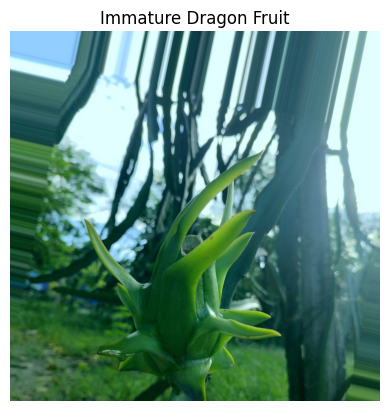

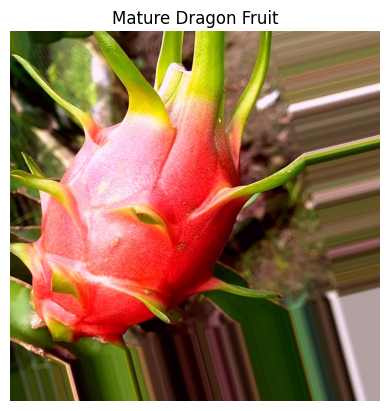

In [2]:
import matplotlib.pyplot as plt
import os

# Path to the train directory
train_dir = '/kaggle/working/train_maturity'

# List all subdirectories (classes) in the train directory
classes = os.listdir(train_dir)

# Display one image from each class
for class_name in classes:
    class_dir = os.path.join(train_dir, class_name)
    images = os.listdir(class_dir)
    
    # Take the first image from each class
    if len(images) > 0:
        image_path = os.path.join(class_dir, images[0])
        image = plt.imread(image_path)
        
        plt.figure()
        plt.title(class_name)
        plt.imshow(image)
        plt.axis('off')
        plt.show()


Found 3200 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/100
100/100 [==============================] - 79s 633ms/step - loss: 0.7224 - accuracy: 0.5891 - val_loss: 0.6097 - val_accuracy: 0.7100
Epoch 2/100
100/100 [==============================] - 62s 623ms/step - loss: 0.5809 - accuracy: 0.7078 - val_loss: 0.5970 - val_accuracy: 0.6450
Epoch 3/100
100/100 [==============================] - 62s 618ms/step - loss: 0.5450 - accuracy: 0.7272 - val_loss: 0.5348 - val_accuracy: 0.7600
Epoch 4/100
100/100 [==============================] - 61s 612ms/step - loss: 0.5122 - accuracy: 0.7525 - val_loss: 0.5235 - val_accuracy: 0.7312
Epoch 5/100
100/100 [==============================] - 62s 616ms/step - loss: 0.5054 - accuracy: 0.7619 - val_loss: 0.5069 - val_accuracy: 0.7462
Epoch 6/100
100/100 [==============================] - 63s 626ms/step - loss: 0.

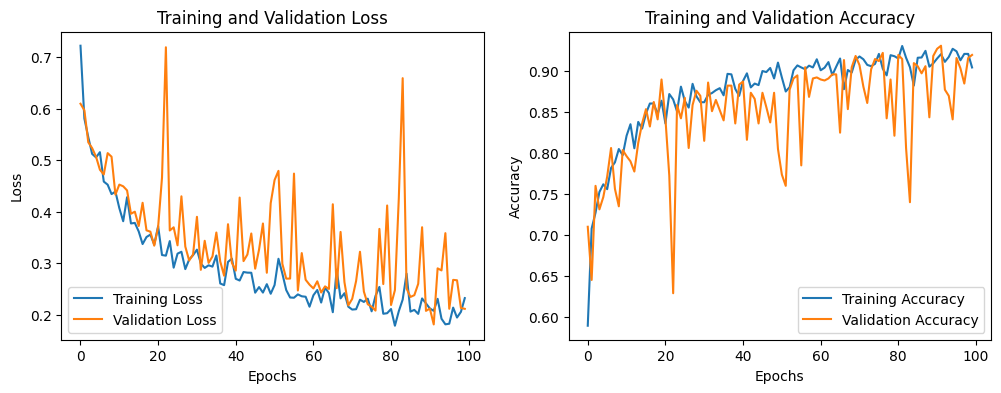

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Define data directories
train_data_dir = '/kaggle/working/train_maturity'
test_data_dir = '/kaggle/working/test_maturity'

img_size = (224, 224)
batch_size = 32

# Create data generators with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2  # 80% training, 20% validation
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Create and compile the ResNet-50 model
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs= 100,  
    validation_data=valid_generator
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_generator)

# Generate predictions for the test data
test_predictions = model.predict(test_generator)
test_pred_labels = np.argmax(test_predictions, axis=1)
test_true_labels = test_generator.classes

# Classification report and confusion matrix
class_labels = list(test_generator.class_indices.keys())
print(classification_report(test_true_labels, test_pred_labels, target_names=class_labels, zero_division=0))
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

# Plot training and validation loss and accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()


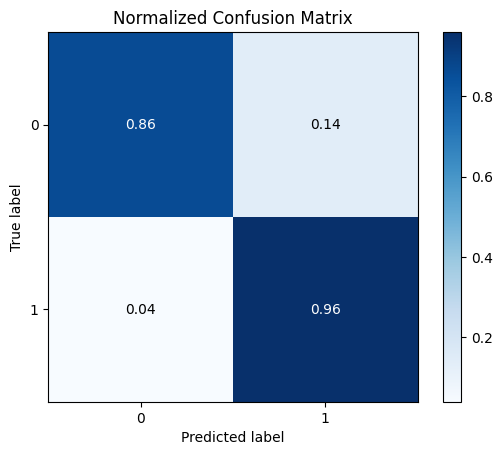

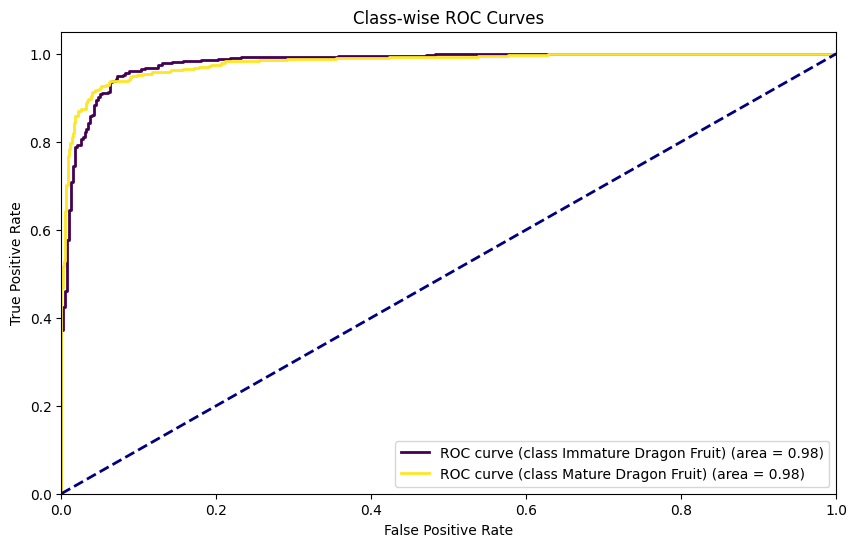

In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import scikitplot as skplt


conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
skplt.metrics.plot_confusion_matrix(test_true_labels, test_pred_labels, normalize=True)
plt.title('Normalized Confusion Matrix')
plt.show()

# Plot class-wise ROC curves
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(test_generator.num_classes):
    fpr[i], tpr[i], _ = roc_curve((test_true_labels == i).astype(int), test_predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, test_generator.num_classes))

for i, color in zip(range(test_generator.num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve (class {class_labels[i]}) (area = {roc_auc[i]:.2f})')


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Class-wise ROC Curves')
plt.legend(loc='lower right')
plt.show()


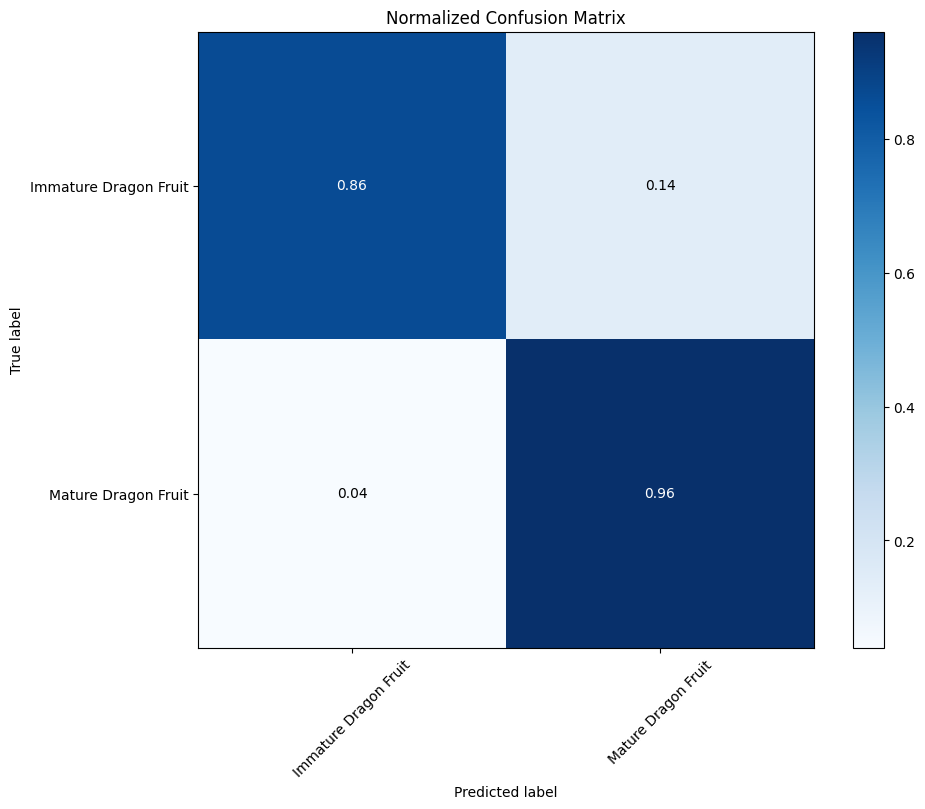

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import scikitplot as skplt

class_names = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
skplt.metrics.plot_confusion_matrix(test_true_labels, test_pred_labels, normalize=True, figsize=(10, 8))
plt.title('Normalized Confusion Matrix')
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.show()


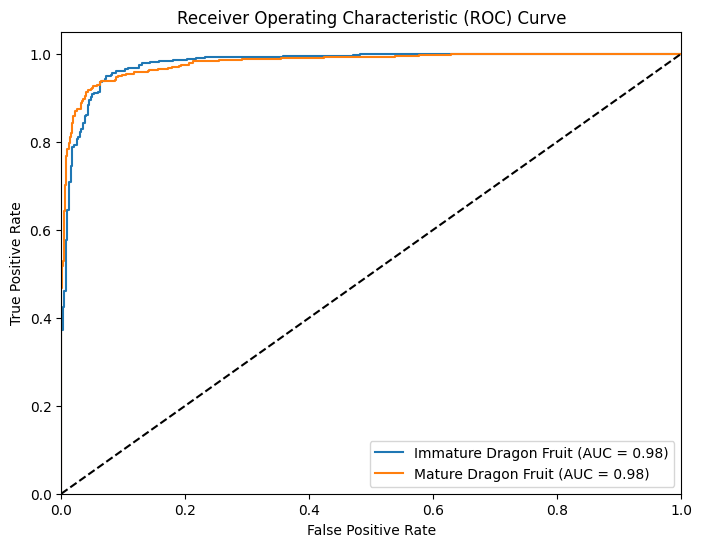

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_labels)):
    fpr[i], tpr[i], _ = roc_curve(test_true_labels == i, test_predictions[:, i])
    roc_auc[i] = roc_auc_score(test_true_labels == i, test_predictions[:, i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(class_labels)):
    plt.plot(fpr[i], tpr[i], label=f'{class_labels[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [7]:
# Classification report and confusion matrix
class_labels = list(test_generator.class_indices.keys())
print(classification_report(test_true_labels, test_pred_labels, target_names=class_labels))
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)


                       precision    recall  f1-score   support

Immature Dragon Fruit       0.97      0.86      0.91       600
  Mature Dragon Fruit       0.82      0.96      0.89       400

             accuracy                           0.90      1000
            macro avg       0.90      0.91      0.90      1000
         weighted avg       0.91      0.90      0.90      1000

